# Importing libraries

In [1]:
import torch
from transformers import AutoTokenizer, AutoModel
from chromadb.config import Settings
from chromadb import Client, PersistentClient
from chromadb.utils.embedding_functions import EmbeddingFunction
from sqlalchemy import create_engine, inspect
import networkx as nx
from typing import Dict, List

In [2]:
# ---------------------------- CONFIGURATION ---------------------------- #
CHROMA_DB_DIR = "./chroma_db"
COLLECTION_NAME = "schema_embeddings"
EMBEDDING_MODEL_NAME = "BAAI/bge-m3"

In [3]:
class ThaiBGEEmbeddingFunction(EmbeddingFunction):
    """
    Embedding function with proper pooling and Thai language support
    """
    def __init__(self, model_name=EMBEDDING_MODEL_NAME):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.model.eval()  # Disable dropout for evaluation

    def __call__(self, texts: List[str]) -> List[List[float]]:
        """
        Generate embeddings for input texts
        Args:
            texts (List[str]): List of strings to embed
        Returns:
            List[List[float]]: List of embeddings
        """
        if isinstance(texts, str):  # Ensure input is a list
            texts = [texts]
        
        inputs = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            return_tensors="pt",
            max_length=512
        )
        with torch.no_grad():
            outputs = self.model(**inputs)
            embeddings = outputs.last_hidden_state[:, 0]  # CLS pooling
        return embeddings.cpu().numpy().tolist()

In [4]:
def process_schema_to_graph_and_embeddings(schema: Dict, chroma_collection, embedding_model) -> nx.DiGraph:
    """
    Process database schema into a graph structure and store embeddings in ChromaDB,
    using M-Schema format for enhanced metadata.
    """
    graph = nx.DiGraph()
    entries = []

    for table_name, details in schema.items():
        # Add table as a node with enriched metadata
        graph.add_node(
            table_name,
            type="table",
            description=details.get("description", ""),
            primary_keys=details.get("primary_keys", []),
            examples=details.get("examples", {})
        )

        # Process columns with M-Schema metadata
        for column in details["columns"]:
            column_id = f"{table_name}.{column['name']}"
            
            # Safely get examples for the column and serialize them
            examples = column.get("examples", [])
            examples_serialized = ", ".join(map(str, examples)) if examples else "None"
            
            graph.add_node(
                column_id,
                type="column",
                table=table_name,
                data_type=column["type"],
                primary_key=column.get("primary_key", False),
                examples=examples_serialized  # Store serialized examples
            )
            graph.add_edge(table_name, column_id, relation="has_column")

            # Add column embedding entry
            column_text = (
                f"Column: {column['name']} ({column['type']}), "
                f"Primary Key: {column.get('primary_key', False)}, "
                f"Examples: {examples_serialized}"
            )
            embedding = embedding_model([column_text])[0]

            entries.append({
                "id": column_id,
                "text": column_text,
                "embedding": embedding,
                "metadata": {
                    "type": "column",
                    "table": table_name,
                    "data_type": column["type"],
                    "primary_key": column.get("primary_key", False),
                    "examples": examples_serialized  # Store serialized examples in metadata
                }
            })

        # Process relationships with enriched metadata
        for relation in details.get("relationships", []):
            rel_id = f"{table_name}.{relation['source_column']}->{relation['target_table']}.{relation['target_column']}"
            
            graph.add_edge(
                table_name,
                relation["target_table"],
                relation="foreign_key",
                source_column=relation["source_column"],
                target_column=relation["target_column"]
            )
            
            # Relationship text for embeddings
            rel_text = (
                f"Foreign Key: {table_name}.{relation['source_column']} → "
                f"{relation['target_table']}.{relation['target_column']}, "
                f"Maps to: {relation.get('maps_to', '')}"
            )
            embedding = embedding_model([rel_text])[0]

            entries.append({
                "id": rel_id,
                "text": rel_text,
                "embedding": embedding,
                "metadata": {
                    "type": "relationship",
                    "source_table": table_name,
                    "source_column": relation["source_column"],
                    "target_table": relation["target_table"],
                    "target_column": relation["target_column"],
                    "maps_to": relation.get("maps_to", "")
                }
            })

    # Debug: Print sample metadata for verification
    if entries:
        print(f"Sample Metadata Entry: {entries[0]['metadata']}")

    # Store embeddings in ChromaDB
    if entries:
        chroma_collection.add(
            ids=[entry["id"] for entry in entries],
            documents=[entry["text"] for entry in entries],
            embeddings=[entry["embedding"] for entry in entries],
            metadatas=[entry["metadata"] for entry in entries]
        )
    
    return graph


In [5]:
# -------------------------- ENHANCED RETRIEVAL ------------------------- #
def retrieve_context(query: str, chroma_collection, embedding_model, graph: nx.DiGraph, max_results: int = 5) -> List[str]:
    """
    Retrieve relevant schema elements based on the query, ensuring only nodes (tables/columns) are included.
    """
    # Generate embedding for the query
    query_embedding = embedding_model([query])[0]
    
    # Query ChromaDB
    results = chroma_collection.query(query_embeddings=[query_embedding], n_results=max_results)
    
    context = []
    for id, metadata_list in zip(results["ids"][0], results["metadatas"][0]):  # Unpacking nested lists
        # Add only valid nodes (tables or columns)
        if id in graph.nodes:
            context.append(id)
        
        # Ensure metadata is a dictionary
        if isinstance(metadata_list, dict) and metadata_list.get("type") == "table":
            # Retrieve neighbors (e.g., columns of the table)
            neighbors = list(graph.neighbors(id))
            context.extend([neighbor for neighbor in neighbors if neighbor in graph.nodes])

    # Deduplicate and limit context size
    return list(set(context))[:max_results]


In [6]:
from sqlalchemy.sql import text  # Import text for raw SQL queries

def extract_database_schema(engine):
    inspector = inspect(engine)
    schema = {}

    # Create a connection for executing SQL queries
    with engine.connect() as connection:
        tables = inspector.get_table_names()

        for table_name in tables:
            schema[table_name] = {"columns": [], "relationships": [], "examples": {}}
            
            # Extract columns
            columns = inspector.get_columns(table_name)
            for column in columns:
                # Add column details with examples
                examples = []  # Retrieve examples from the database
                try:
                    # Use sqlalchemy.text to create a valid SQL query object
                    query = text(f"SELECT {column['name']} FROM {table_name} LIMIT 3")
                    examples = [row[0] for row in connection.execute(query).fetchall()]
                except Exception as e:
                    print(f"Failed to fetch examples for {table_name}.{column['name']}: {e}")
                
                schema[table_name]["columns"].append({
                    "name": column["name"],
                    "type": str(column["type"]).split("(")[0],
                    "examples": examples
                })

            # Extract foreign keys
            foreign_keys = inspector.get_foreign_keys(table_name)
            for fk in foreign_keys:
                schema[table_name]["relationships"].append({
                    "source_column": fk["constrained_columns"][0],
                    "target_table": fk["referred_table"],
                    "target_column": fk["referred_columns"][0]
                })

    return schema


In [7]:
def keyword_search(query: str, schema: Dict) -> List[str]:
    """
    Perform keyword search to find schema elements directly matching query keywords.
    Args:
        query (str): User's natural language query.
        schema (Dict): Extracted database schema.
    Returns:
        List[str]: List of schema elements matching the query keywords.
    """
    keywords = query.lower().split()  # Split the query into individual words
    matches = []

    for table, details in schema.items():
        # Match table names
        if any(keyword in table.lower() for keyword in keywords):
            matches.append(table)

        # Match column names
        for column in details["columns"]:
            if any(keyword in column["name"].lower() for keyword in keywords):
                matches.append(f"{table}.{column['name']}")

    return matches


In [8]:
def semantic_search(query: str, chroma_collection, embedding_model, max_results: int = 10) -> List[str]:
    """
    Perform semantic search to retrieve schema elements based on embeddings.
    Args:
        query (str): User's natural language query.
        chroma_collection: ChromaDB collection.
        embedding_model: Embedding model for generating embeddings.
        max_results (int): Maximum number of results to return.
    Returns:
        List[str]: List of schema elements matching the query semantically.
    """
    # Generate embedding for the query
    query_embedding = embedding_model([query])[0]
    
    # Query ChromaDB
    results = chroma_collection.query(query_embeddings=[query_embedding], n_results=max_results)
    
    # Extract IDs of matching schema elements
    return results["ids"][0]


In [1]:
def hybrid_search(
    query: str,
    schema: Dict,
    chroma_collection,
    embedding_model,
    max_results: int = 15
) -> List[str]:
    """
    Combine keyword search and semantic search for hybrid retrieval.
    Args:
        query (str): User's natural language query.
        schema (Dict): Extracted database schema.
        chroma_collection: ChromaDB collection.
        embedding_model: Embedding model for generating embeddings.
        max_results (int): Maximum number of results to return.
    Returns:
        List[str]: Combined results from keyword and semantic search.
    """
    # Perform keyword search
    keyword_matches = keyword_search(query, schema)

    # Perform semantic search
    semantic_matches = semantic_search(query, chroma_collection, embedding_model, max_results)

    # Combine and deduplicate results
    combined_matches = list(set(keyword_matches + semantic_matches))

    # Limit results to max_results
    return combined_matches[:max_results]


NameError: name 'Dict' is not defined

In [2]:
def assemble_prompt(query: str, context: List[str], graph: nx.DiGraph) -> str:
    """
    Build a structured and optimized prompt with schema context, highlighting relevant parts
    and including enriched metadata like examples and primary keys.
    """
    prompt_lines = [
        "### Task",
        "Translate the following natural language query into an SQL query:",
        "",
        f"### Query\n{query}",
        "",
        "### Relevant Schema Information"
    ]

    # Collect relevant tables and their metadata
    relevant_tables = set()
    for node in context:
        try:
            if graph.nodes[node]["type"] == "table":
                relevant_tables.add(node)
            elif graph.nodes[node]["type"] == "column":
                relevant_tables.add(graph.nodes[node]["table"])
        except KeyError:
            continue  # Skip nodes that lack necessary attributes

    # Add details for relevant tables and columns
    for table in relevant_tables:
        table_metadata = graph.nodes[table]
        primary_keys = table_metadata.get("primary_keys", [])
        examples = table_metadata.get("examples", {})
        prompt_lines.append(f"\nTable: {table}")
        if primary_keys:
            prompt_lines.append(f"  - Primary Keys: {', '.join(primary_keys)}")
        if examples:
            prompt_lines.append(f"  - Examples: {examples}")

        # Add column details
        for neighbor in graph.neighbors(table):
            try:
                if graph.nodes[neighbor]["type"] == "column":
                    column_metadata = graph.nodes[neighbor]
                    column_name = neighbor.split(".")[1]
                    column_type = column_metadata["data_type"]
                    primary_key = column_metadata.get("primary_key", False)
                    column_examples = column_metadata.get("examples", [])

                    # Highlight relevant columns
                    if neighbor in context:
                        prompt_lines.append(
                            f"  - {column_name} ({column_type}) [RELEVANT] - "
                            f"{'Primary Key' if primary_key else ''} "
                            f"{f'Examples: {column_examples}' if column_examples else ''}"
                        )
                    else:
                        prompt_lines.append(
                            f"  - {column_name} ({column_type}) - "
                            f"{'Primary Key' if primary_key else ''} "
                            f"{f'Examples: {column_examples}' if column_examples else ''}"
                        )
            except KeyError:
                continue

    # Add relevant relationships
    prompt_lines.append("\n### Relationships")
    for edge in graph.edges(data=True):
        if edge[2].get("relation") == "foreign_key":
            source = edge[0]
            target = edge[1]
            source_col = edge[2]["source_column"]
            target_col = edge[2]["target_column"]
            maps_to = edge[2].get("maps_to", "")
            relationship_examples = edge[2].get("examples", [])
            if source in relevant_tables or target in relevant_tables:
                prompt_lines.append(
                    f"  - {source} ({source_col}) → {target} ({target_col}) [RELEVANT] "
                    f"{f'Maps to: {maps_to}' if maps_to else ''} "
                    f"{f'Examples: {relationship_examples}' if relationship_examples else ''}"
                )

    # Final instructions
    prompt_lines.append("\n### SQL Query")
    prompt_lines.append("-- Write the SQL query below this line --")

    return "\n".join(prompt_lines)


NameError: name 'List' is not defined

In [11]:
def setup_chroma_db():
    """
    Initialize ChromaDB and ensure collection matches embedding dimension
    """
    chroma_client = PersistentClient(path=CHROMA_DB_DIR)
    try:
        # Try to get the collection
        collection = chroma_client.get_collection(COLLECTION_NAME)
    except Exception:
        # Create collection with correct embedding function and dimension
        collection = chroma_client.create_collection(
            name=COLLECTION_NAME,
            embedding_function=ThaiBGEEmbeddingFunction()
        )
    return chroma_client, collection

In [12]:
if __name__ == "__main__":
    # Database connection
    engine = create_engine("sqlite:///example.db")

    # Extract schema
    schema = extract_database_schema(engine)

    # Set up ChromaDB
    chroma_client, collection = setup_chroma_db()
    embedding_model = ThaiBGEEmbeddingFunction()

    # Process schema
    graph = process_schema_to_graph_and_embeddings(schema, collection, embedding_model)

    # Example query
    user_query = "Show me every food name, price and ingredients."

    # Perform keyword search
    keyword_results = keyword_search(user_query, schema)
    print("Keyword Search Results:", keyword_results)

    # Perform semantic search
    semantic_results = semantic_search(user_query, collection, embedding_model)
    print("Semantic Search Results:", semantic_results)

    # Perform hybrid search
    hybrid_results = hybrid_search(user_query, schema, collection, embedding_model)
    print("Hybrid Search Results:", hybrid_results)

    # Use hybrid search results as context
    context = hybrid_search(user_query, schema, collection, embedding_model)

    # Generate prompt
    prompt = assemble_prompt(user_query, context, graph)
    print("Generated Prompt:\n", prompt)


Add of existing embedding ID: schedules.employee_id->employees.id
Add of existing embedding ID: suppliers.id
Add of existing embedding ID: suppliers.name
Add of existing embedding ID: suppliers.contact_email
Add of existing embedding ID: user_activity.id
Add of existing embedding ID: user_activity.user_id
Add of existing embedding ID: user_activity.activity_date
Add of existing embedding ID: user_activity.description
Add of existing embedding ID: user_activity.user_id->users.id
Add of existing embedding ID: users.id
Add of existing embedding ID: users.name
Add of existing embedding ID: users.age
Add of existing embedding ID: users.email
Add of existing embedding ID: vendors.id
Add of existing embedding ID: vendors.name
Add of existing embedding ID: vendors.contact_info
Add of existing embedding ID: coupons.id
Add of existing embedding ID: coupons.code
Add of existing embedding ID: coupons.discount_percentage
Add of existing embedding ID: coupons.expiration_date
Add of existing embeddin

Sample Metadata Entry: {'type': 'column', 'table': 'coupons', 'data_type': 'INTEGER', 'primary_key': False, 'examples': '3, 4, 9'}
Keyword Search Results: ['discounts.food_id', 'employees.name', 'food', 'food.name', 'food.price', 'food_category', 'food_category.name', 'food_category_mapping', 'food_category_mapping.food_id', 'ingredients.name', 'loyalty_program.membership_tier', 'orders.food_id', 'payments', 'payments.payment_date', 'promotions.food_id', 'recipes.food_id', 'reviews.food_id', 'suppliers.name', 'users.name', 'vendors.name']
Semantic Search Results: ['food.price', 'discounts.food_id', 'recipes.food_id', 'ingredients.cost_per_unit', 'ingredients.name', 'orders.food_id', 'food.name', 'food.id', 'recipes.ingredient_id', 'discounts.food_id->food.id']
Hybrid Search Results: ['food', 'food.name', 'loyalty_program.membership_tier', 'promotions.food_id', 'users.name', 'ingredients.cost_per_unit', 'orders.food_id', 'food_category_mapping', 'food_category.name', 'payments']
Generat

In [13]:
import matplotlib.pyplot as plt

def visualize_graph(graph: nx.DiGraph):
    """
    Visualize the database schema graph.
    Args:
        graph (nx.DiGraph): The graph representing the schema.
    """
    plt.figure(figsize=(24, 24))

    # Draw the graph
    pos = nx.spring_layout(graph)  # Layout algorithm for better spacing
    nx.draw(
        graph, pos,
        with_labels=True,
        node_size=3000,
        font_size=10,
        node_color="lightblue",
        edge_color="gray",
        font_weight="bold",
        arrowsize=20
    )

    # Draw edge labels (e.g., foreign keys)
    edge_labels = nx.get_edge_attributes(graph, "relation")
    nx.draw_networkx_edge_labels(
        graph, pos,
        edge_labels=edge_labels,
        font_size=9,
        label_pos=0.5
    )

    # Show the plot
    plt.title("Database Schema Graph")
    plt.show()


Add of existing embedding ID: coupons.id
Add of existing embedding ID: coupons.code
Add of existing embedding ID: coupons.discount_percentage
Add of existing embedding ID: coupons.expiration_date
Add of existing embedding ID: discounts.id
Add of existing embedding ID: discounts.food_id
Add of existing embedding ID: discounts.discount_percentage
Add of existing embedding ID: discounts.food_id->food.id
Add of existing embedding ID: employees.id
Add of existing embedding ID: employees.name
Add of existing embedding ID: employees.position
Add of existing embedding ID: employees.salary
Add of existing embedding ID: food.id
Add of existing embedding ID: food.name
Add of existing embedding ID: food.price
Add of existing embedding ID: food_category.id
Add of existing embedding ID: food_category.name
Add of existing embedding ID: food_category_mapping.id
Add of existing embedding ID: food_category_mapping.food_id
Add of existing embedding ID: food_category_mapping.category_id
Add of existing em

Sample Metadata Entry: {'type': 'column', 'table': 'coupons', 'data_type': 'INTEGER', 'primary_key': False, 'examples': '3, 4, 9'}


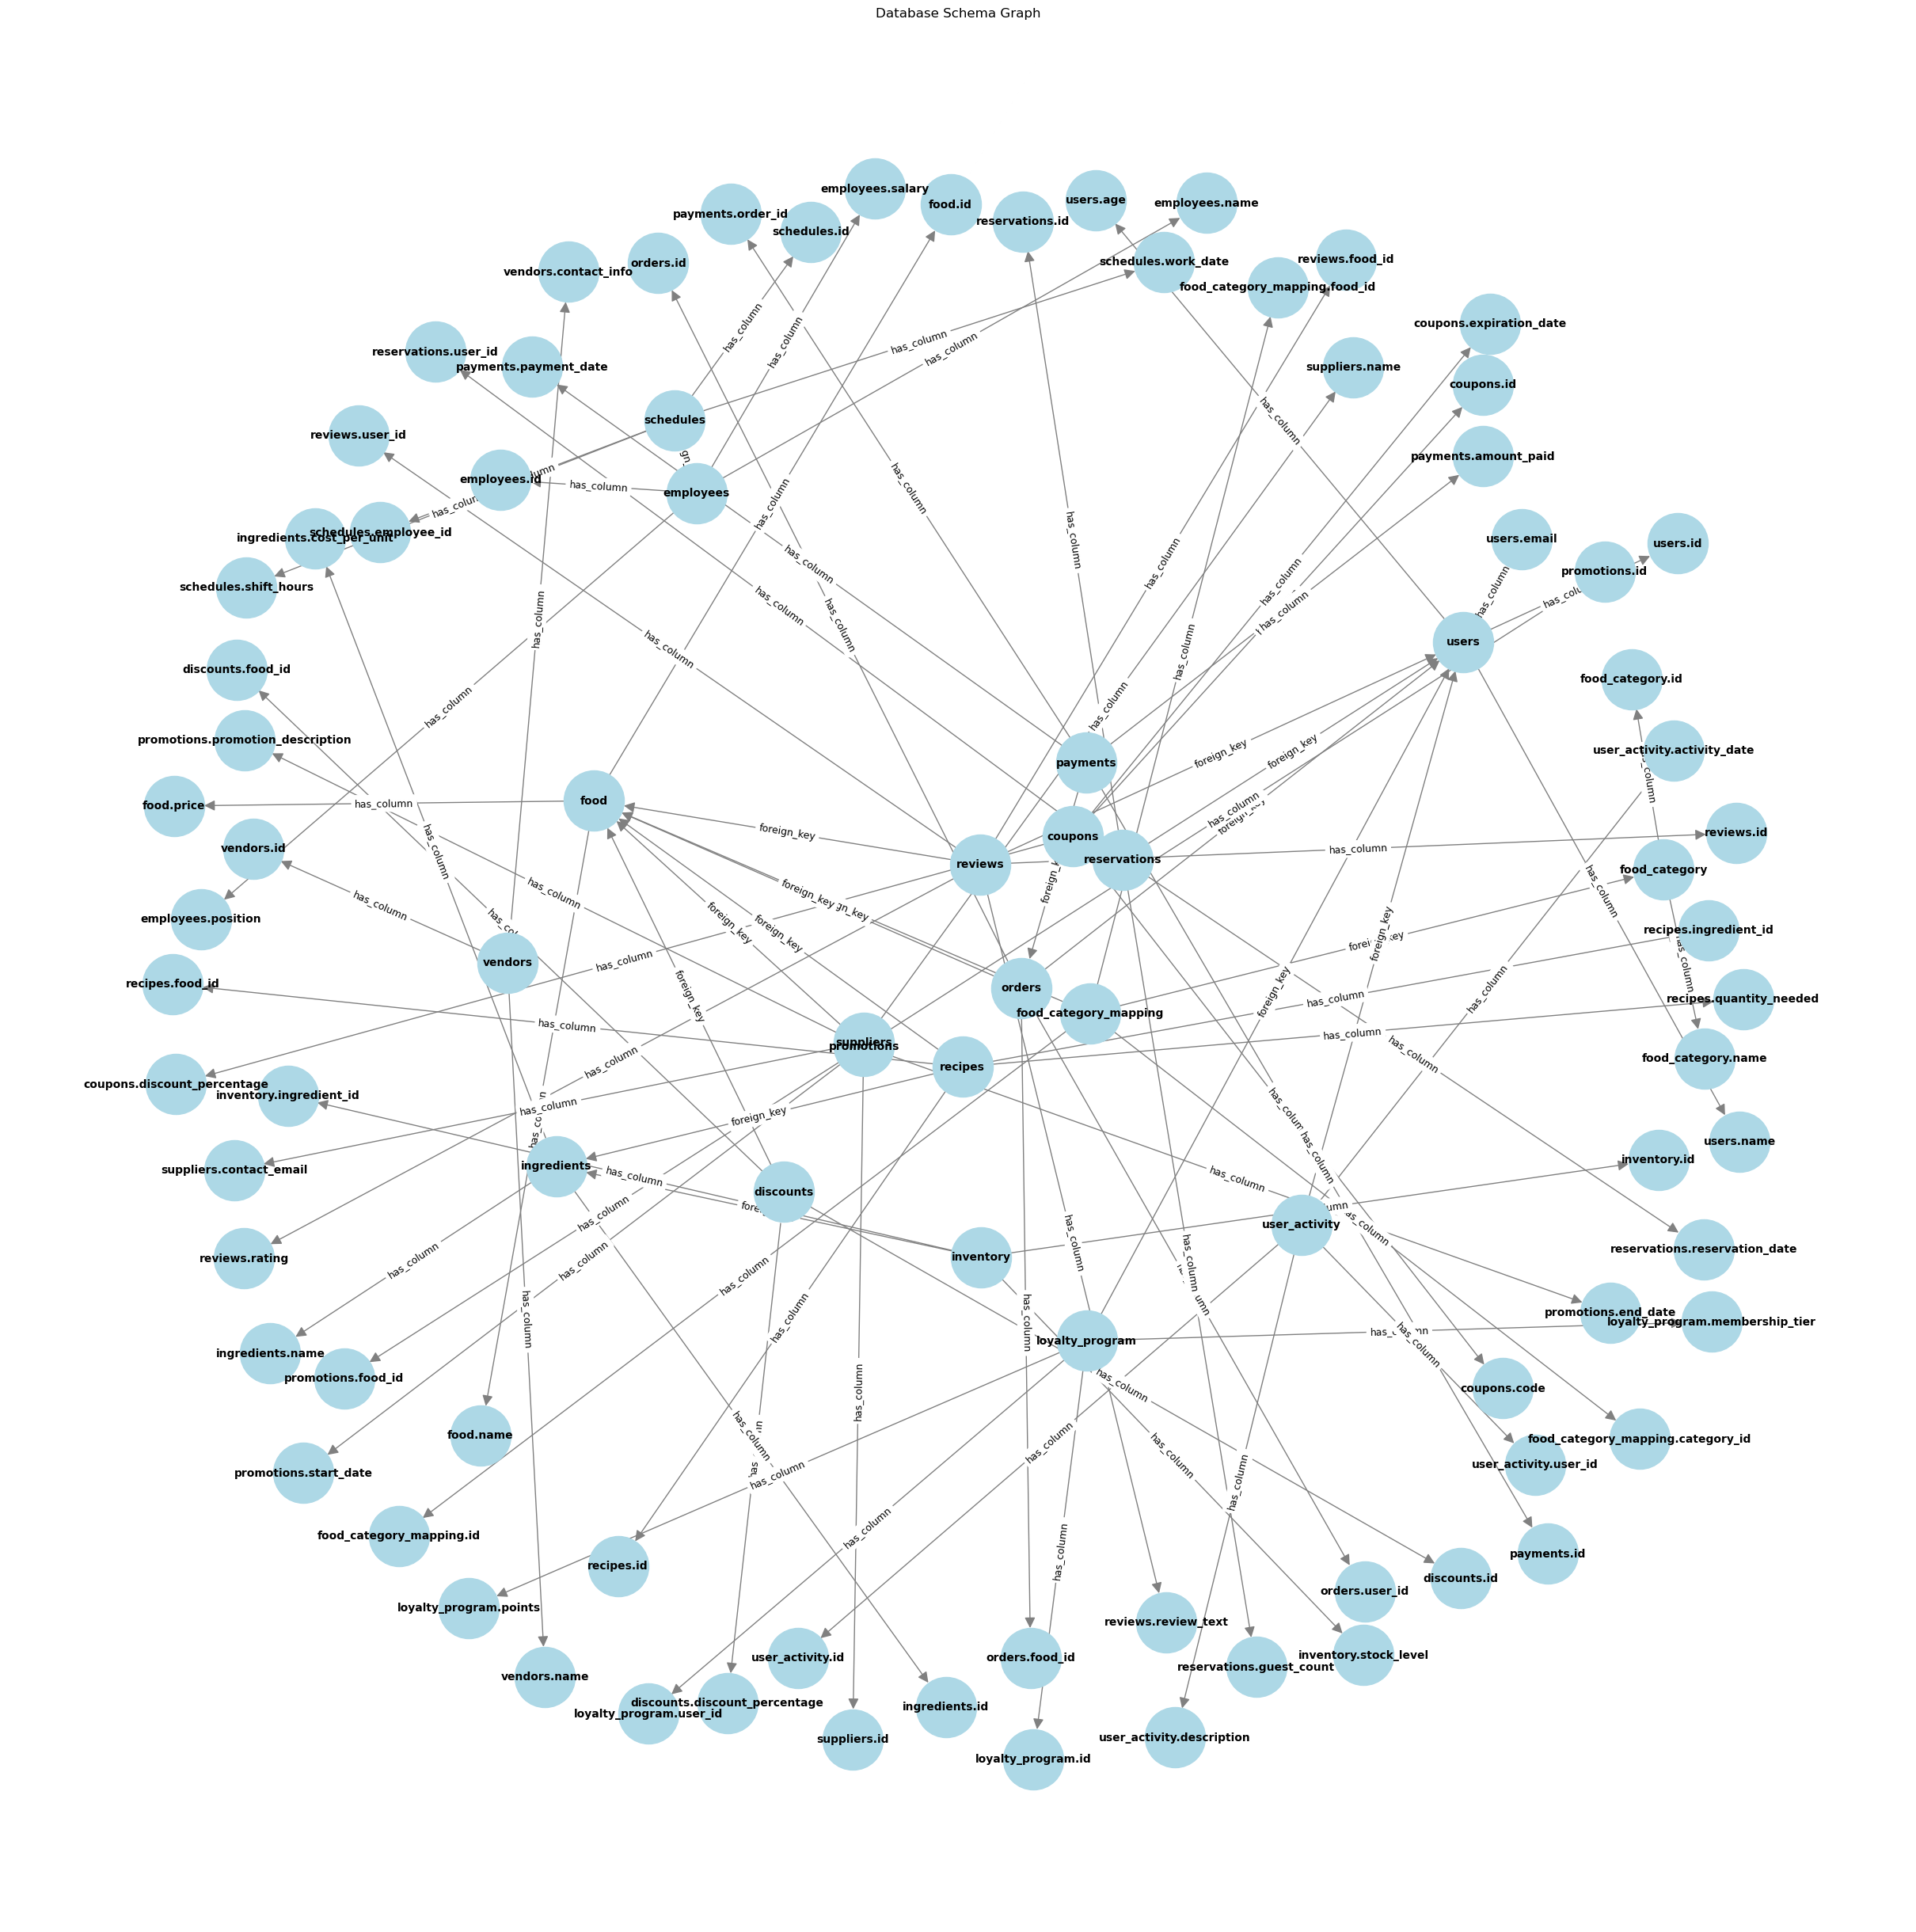

In [14]:
# Process schema into a graph
graph = process_schema_to_graph_and_embeddings(schema, collection, embedding_model)

# Visualize the graph
visualize_graph(graph)


# Vanna


In [ ]:
#%pip install vanna

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.
